# POC - 1 2 3 Custom MXNet Container – What does it mean? 

In [1]:
!sudo yum install -y tree

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
amzn-main                                                | 2.1 kB     00:00     
amzn-updates                                             | 3.8 kB     00:00     
Package tree-1.6.0-5.8.amzn1.x86_64 already installed and latest version
Nothing to do


In [2]:
!tree model_untarred

model_untarred
├── code
│   ├── compile.sh
│   ├── image_pb2.py
│   ├── image.proto
│   ├── inference-Copy1.py
│   ├── inference.py
│   ├── __init__.py
│   └── protobuf.tar.gz
├── resnet-152-0000.params
├── resnet-152-shapes.json
└── resnet-152-symbol.json

1 directory, 10 files


In [3]:
!pygmentize inference.py

#LOCAL inference.py - EDIT THIS

import mxnet as mx
import os
import json
import numpy as np
from collections import namedtuple
import logging
import cv2
import PIL
from PIL import Image
import io

logger = logging.getLogger()
logger.setLevel(logging.INFO)

import image_pb2 as impb
image_packet = impb.PBImage()
        

print('~inference.py')

# Use GPU if one exists, else use CPU
ctx = mx.gpu()

dtype='float32'
Batch = namedtuple('Batch', ['data'])

mod = None
def model_fn(model_dir):
    
    logger.info("\nmodel_fn\n")
    
    sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', 0)
    mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)    
    
    mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], label_shapes=mod._label_shapes)
    mod.set_params(arg_params, aux_params, allow_missing=True)
    
    return mod


def transform_fn(mod, img, input_content_type, output_content_type):
    
    logger.info("\ntransform_fn\n")
    
    prob_j

In [4]:
!rm -rfv model_untarred/code/protobuf.tar.gz
!(cd model_untarred/code/ && tar -czvf protobuf.tar.gz __init__.py image_pb2.py)

removed ‘model_untarred/code/protobuf.tar.gz’
__init__.py
image_pb2.py


In [5]:
!(cd model_untarred/ && tar -czvf /tmp/model-resnet-152-inference.tar.gz *)

code/
code/image.proto
code/inference-Copy1.py
code/compile.sh
code/.ipynb_checkpoints/
code/.ipynb_checkpoints/__init__-checkpoint.py
code/.ipynb_checkpoints/compile-checkpoint.sh
code/.ipynb_checkpoints/inference-checkpoint.py
code/.ipynb_checkpoints/image-checkpoint.proto
code/protobuf.tar.gz
code/__init__.py
code/image_pb2.py
code/inference.py
resnet-152-0000.params
resnet-152-shapes.json
resnet-152-symbol.json


In [6]:
!aws s3 cp /tmp/model-resnet-152-inference.tar.gz s3://ar54/super_models/
!aws s3 ls s3://ar54/super_models/

upload: ../../../../../../../tmp/model-resnet-152-inference.tar.gz to s3://ar54/super_models/model-resnet-152-inference.tar.gz
2020-05-22 06:50:50          0 
2020-05-25 21:30:38   41996630 model-image-classification-inference.tar.gz
2020-08-12 21:15:41  225270648 model-resnet-152-inference.tar.gz
2020-05-22 19:56:25  225558652 model-resnet-152-withinference.tar.gz
2020-08-11 23:46:07  235487330 model-rfcn.tar.gz
2020-05-25 21:40:39  235501307 model-rfcn_dcn_coco-inference.tar.gz
2020-05-23 08:29:25  225268422 model-with-inference.tar.gz
2020-06-13 15:15:07  654033042 model-yolo-inference.tar.gz
2020-05-22 16:08:07     406427 mxnet-test-model.tar.gz
2020-05-23 06:35:40  225570879 resnet_152.tar.gz
2020-05-23 06:35:40   43466655 resnet_18.tar.gz


In [7]:
!aws s3 ls s3://ar54/super_models/model-resnet-152-inference.tar.gz

2020-08-12 21:15:41  225270648 model-resnet-152-inference.tar.gz


In [8]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import nd, autograd, gluon
from mxnet.gluon.data.vision import transforms

import numpy as np

model_arch_path = '/home/ec2-user/SageMaker/resnet-inference-model/model_untarred/resnet-152-symbol.json'
model_params_path = '/home/ec2-user/SageMaker/resnet-inference-model/model_untarred/resnet-152-0000.params'

# Use GPU if one exists, else use CPU
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()
symbol = mx.sym.load(model_arch_path)

#mx.viz.print_summary(symbol)

In [9]:
%%sh

# The name of our algorithm
algorithm_name=chazarey-retry-mxnet-serving-160-gpu-py3

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
#region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

#docker build -t chazarey-mxnet-serving:1.6.0-gpu-py3 -f docker/1.6.0/py3/Dockerfile.gpu .

docker build -t ${algorithm_name} -f Dockerfile.gpu .

docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  761.8MB
Step 1/28 : FROM nvidia/cuda:10.1-cudnn7-runtime-ubuntu16.04
 ---> e11e11484e2e
Step 2/28 : LABEL maintainer="Amazon AI"
 ---> Using cache
 ---> 8aa5fed14ba8
Step 3/28 : LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true
 ---> Using cache
 ---> 43a725275707
Step 4/28 : ARG MMS_VERSION=1.0.8
 ---> Using cache
 ---> 85d869dac12d
Step 5/28 : ARG MX_URL=https://aws-mxnet-pypi.s3-us-west-2.amazonaws.com/1.6.0/aws_mxnet_cu101mkl-1.6.0-py2.py3-none-manylinux1_x86_64.whl
 ---> Using cache
 ---> 1eb3b5ec706a
Step 6/28 : ARG PYTHON=python3
 ---> Using cache
 ---> 675f8de2976b
Step 7/28 : ARG PYTHON_PIP=python3-pip
 ---> Using cache
 ---> f436d426e875
Step 8/28 : ARG PIP=pip3
 ---> Using cache
 ---> 94a1aaea9091
Step 9/28 : ARG PYTHON_VERSION=3.6.8
 ---> Using cache
 ---> a1701a0394f3
Step 10/28 : ENV PYTHONDONTWRITEBYTECODE=1     PYTHONUNBUFFERED=1     LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/usr/local/lib"     PYTHONIO

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [10]:
import sagemaker

role = sagemaker.session.get_execution_role()

from sagemaker.mxnet import MXNetModel

model_data="s3://ar54/super_models/model-resnet-152-inference.tar.gz"

model = MXNetModel(
    model_data=model_data,
    role=role,
    image="308412838853.dkr.ecr.us-east-2.amazonaws.com/chazarey-retry-mxnet-serving-160-gpu-py3:latest",
    entry_point="inference.py",
    py_version='py3',
    framework_version='1.6.0',
    enable_cloudwatch_metrics=True
)
# ml.g4dn.16xlarge ml.p3.16xlarge ml.p2.xlarge
#predictor = model.deploy(instance_type="local_gpu", initial_instance_count=1)
predictor = model.deploy(instance_type='ml.g4dn.xlarge', initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [11]:
print(predictor.endpoint)

chazarey-retry-mxnet-serving-160-gpu-py-2020-08-12-21-16-10-758


In [12]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

--2020-08-12 21:22:42--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-08-12 21:22:42 ERROR 404: Not Found.



In [21]:
file_name = '/home/ec2-user/SageMaker/dataset/769452-1.2.jpg'
# test image
from IPython.display import Image
#Image(file_name)  

In [22]:
import json

json.dumps(['foo', {'bar': ('baz', None, 1.0, 2)}])

'["foo", {"bar": ["baz", null, 1.0, 2]}]'

In [23]:
iii = '''import io
import numpy as np
import json
from sagemaker.predictor import StringDeserializer
import time
import ast 

def numpy_bytes_serializer(data):
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = None

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

for i in range(0, 1):    
    response = predictor.predict(payload)            
    time.sleep(1)
    result = ast.literal_eval(response)
    index = np.argmax(result)
    print(index)

'''
#response

In [24]:
import io
import numpy as np
import json
from sagemaker.predictor import StringDeserializer
import time
import ast 

def numpy_bytes_serializer(data):
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = None

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

for i in range(0, 1):    
    %time response = predictor.predict(payload)            
    print(response)

#response

CPU times: user 15.5 ms, sys: 4.62 ms, total: 20.1 ms
Wall time: 121 ms
["foo", {"bar": ["baz", null, 1.0, 2]}]


In [45]:
!dd if=/dev/urandom of=payload.bin bs=$((1*1024*1024)) count=1
#!dd if=/dev/urandom of=payload.bin bs=$((1*1024)) count=1
!ls -alh payload.bin

1+0 records in
1+0 records out
1048576 bytes (1.0 MB) copied, 0.00635941 s, 165 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 1.0M Aug 12 22:17 payload.bin


In [65]:
for size in range(1, 20):
    size = size*100*1024
    !dd if=/dev/urandom of=payload.bin bs={size} count=1
    !ls -alh payload.bin

1+0 records in
1+0 records out
102400 bytes (102 kB) copied, 0.000783899 s, 131 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 100K Aug 12 22:27 payload.bin
1+0 records in
1+0 records out
204800 bytes (205 kB) copied, 0.00140031 s, 146 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 200K Aug 12 22:27 payload.bin
1+0 records in
1+0 records out
307200 bytes (307 kB) copied, 0.00196642 s, 156 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 300K Aug 12 22:27 payload.bin
1+0 records in
1+0 records out
409600 bytes (410 kB) copied, 0.00259277 s, 158 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 400K Aug 12 22:27 payload.bin
1+0 records in
1+0 records out
512000 bytes (512 kB) copied, 0.00316969 s, 162 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 500K Aug 12 22:27 payload.bin
1+0 records in
1+0 records out
614400 bytes (614 kB) copied, 0.00373026 s, 165 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 600K Aug 12 22:27 payload.bin
1+0 records in
1+0 records out
716800 bytes (717 kB) copied, 0.00435889 s, 164 MB/s
-rw-rw-r-- 1 ec2-user ec2-user 700K Aug 12 22

In [46]:
file_name = 'payload.bin'

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

In [47]:
import io
import numpy as np
import json
from sagemaker.predictor import StringDeserializer
import time
import ast 

def numpy_bytes_serializer(data):
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = None

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

for i in range(0, 1):    
    %time response = predictor.predict(payload)            
    print(response)

#response

CPU times: user 17.9 ms, sys: 497 µs, total: 18.4 ms
Wall time: 86.8 ms
["foo", {"bar": ["baz", null, 1.0, 2]}]


In [48]:
import numpy as np 
import datetime
import math
import time
import boto3   
import matplotlib.pyplot as plt

endpoint_name=predictor.endpoint
total_runs=1000

In [49]:
print('Running {} inferences for {}:'.format(total_runs, endpoint_name))

client_times = []
cw_start = datetime.datetime.utcnow()

for i in range(total_runs):    
    
    client_start = time.time()
    
    response = predictor.predict(payload) 
        
    client_end = time.time()
    client_times.append((client_end - client_start)*1000)

cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))

print('Getting Cloudwatch:')
cloudwatch = boto3.client('cloudwatch')
statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
extended=['p50', 'p90', 'p95', 'p100']

# Give 5 minute buffer to end
cw_end += datetime.timedelta(minutes=5)

# Period must be 1, 5, 10, 30, or multiple of 60
# Calculate closest multiple of 60 to the total elapsed time
factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
period = factor * 60
period = int(period)

print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
print('Using period of {} seconds\n'.format(period))

cloudwatch_ready = False
# Keep polling CloudWatch metrics until datapoints are available
while not cloudwatch_ready:
    time.sleep(30)
    print('Waiting 30 seconds ...')
    # Must use default units of microseconds
    model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )
          #Should be 1000
    if len(model_latency_metrics['Datapoints']) > 0:
            print('{} ModelLatency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
            side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
            side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
            side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
            side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
            side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
            print('Avg | P50 | P90 | P95 | P100')
            print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))   

    time.sleep(30)        
    model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='OverheadLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )
          #Should be 1000
    if len(model_latency_metrics['Datapoints']) > 0:
            print('{} OverheadLatency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
            side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
            side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
            side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
            side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
            side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
            print('Avg | P50 | P90 | P95 | P100')
            print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))   
            
            
            
    cloudwatch_ready = True
    

Running 1 inferences for chazarey-retry-mxnet-serving-160-gpu-py-2020-08-12-21-16-10-758:
Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
24.1320 | 24.1320 | 24.1320 | 24.1320

Getting Cloudwatch:
Time elapsed: 300.0243 seconds
Using period of 360 seconds

Waiting 30 seconds ...


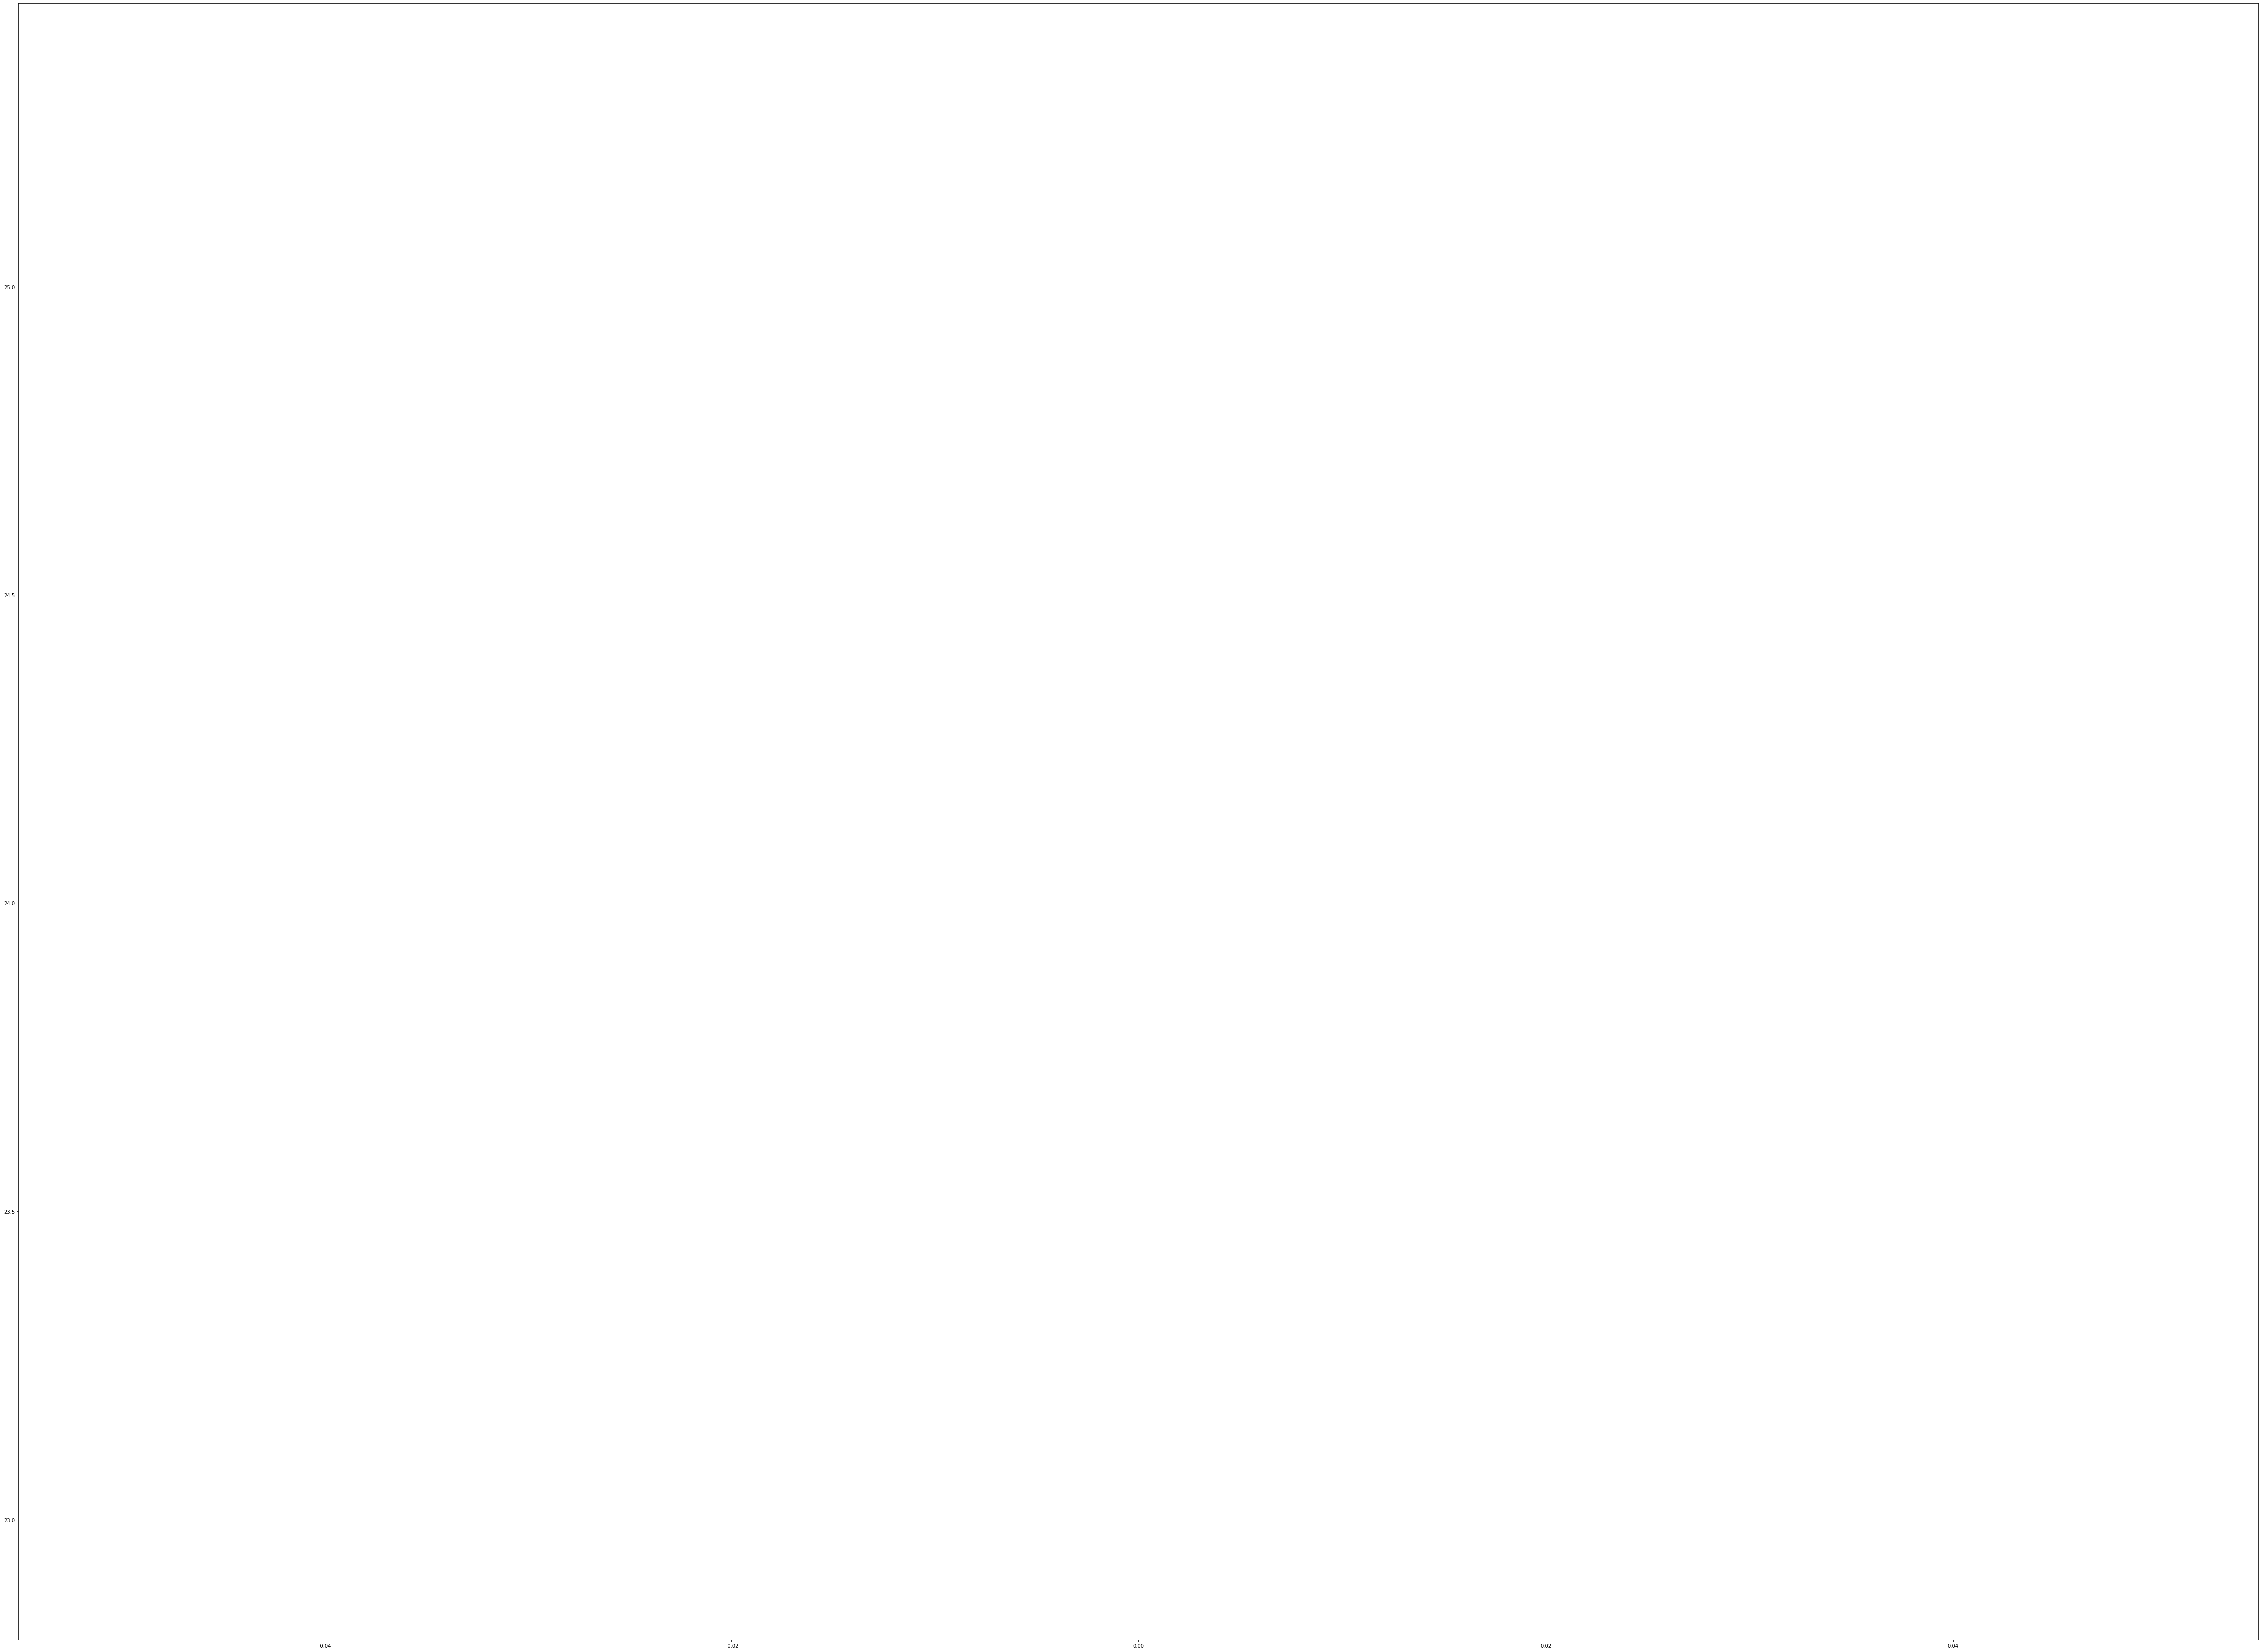

In [62]:
fig = plt.figure(figsize=(80, 60))
ax = fig.add_subplot(111)
ax.plot(client_times)

In [84]:
import pandas as pd 

df = pd.DataFrame(columns=['payload-size','runs','e2e-avg','e2e-p50','e2e-p90','e2e-p95','e2e-p100','mlat-avg','mlat-p50','mlat-p90','mlat-p95','mlat-p100','olat-avg','olat-p50','olat-p90','olat-p95','olat-p100'])

print("Empty Dataframe ", df, sep='\n')

dict_add = {'payload-size': 0.0,
            'runs': 0.0,
            'e2e-avg': 0.0,
            'e2e-p50': 0.0,
            'e2e-p90': 0.0,
            'e2e-p95': 0.0,
            'e2e-p100': 0.0,
            'mlat-avg': 0.0,
            'mlat-p50': 0.0,
            'mlat-p90': 0.0,
            'mlat-p95': 0.0,
            'mlat-p100': 0.0,
            'olat-avg': 0.0,
            'olat-p50': 0.0,
            'olat-p90': 0.0,
            'olat-p95': 0.0,
            'olat-p100': 0.0}

dict_add['payload-size'] = 100
dict_add['runs'] = 100
dict_add['e2e-avg'] = 100
dict_add['e2e-p50'] = 100
dict_add['e2e-p90'] = 100
dict_add['e2e-p95'] = 100
dict_add['e2e-p100'] = 100
dict_add['mlat-avg'] = 100
dict_add['mlat-p50'] = 100
dict_add['mlat-p90'] = 100
dict_add['mlat-p95'] = 100
dict_add['mlat-p100'] = 100
dict_add['olat-avg'] = 100
dict_add['olat-p50'] = 100
dict_add['olat-p90'] = 100
dict_add['olat-p95'] = 100
dict_add['olat-p100'] = 100

df = df.append(dict_add, ignore_index=True)
df

Empty Dataframe 
Empty DataFrame
Columns: [payload-size, runs, e2e-avg, e2e-p50, e2e-p90, e2e-p95, e2e-p100, mlat-avg, mlat-p50, mlat-p90, mlat-p95, mlat-p100, olat-avg, olat-p50, olat-p90, olat-p95, olat-p100]
Index: []


,payload-size,runs,e2e-avg,e2e-p50,e2e-p90,e2e-p95,e2e-p100,mlat-avg,mlat-p50,mlat-p90,mlat-p95,mlat-p100,olat-avg,olat-p50,olat-p90,olat-p95,olat-p100
0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [96]:
df = pd.DataFrame(columns=['payload-size','runs','e2e-avg','e2e-p50','e2e-p90','e2e-p95','e2e-p100','mlat-avg','mlat-p50','mlat-p90','mlat-p95','mlat-p100','olat-avg','olat-p50','olat-p90','olat-p95','olat-p100'])

dict_add = {'payload-size': 0.0,
            'runs': 0.0,
            'e2e-avg': 0.0,
            'e2e-p50': 0.0,
            'e2e-p90': 0.0,
            'e2e-p95': 0.0,
            'e2e-p100': 0.0,
            'mlat-avg': 0.0,
            'mlat-p50': 0.0,
            'mlat-p90': 0.0,
            'mlat-p95': 0.0,
            'mlat-p100': 0.0,
            'olat-avg': 0.0,
            'olat-p50': 0.0,
            'olat-p90': 0.0,
            'olat-p95': 0.0,
            'olat-p100': 0.0}

for size in range(1, 3):
    #time.sleep(30)
    size = size*100*1024
    
    dict_add['payload-size'] = size
    
    !dd if=/dev/urandom of=payload.bin bs={size} count=1 status=none
    
    endpoint_name=predictor.endpoint
    total_runs=1000

    !ls -alh payload.bin
    
    file_name = 'payload.bin'
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    
    client_times = []
    print('Running {} inferences for {}:'.format(total_runs, endpoint_name))
    cw_start = datetime.datetime.utcnow()

    for i in range(total_runs):    
        client_start = time.time()
        dict_add['runs'] = i

        response = predictor.predict(payload) 

        client_end = time.time()
        client_times.append((client_end - client_start)*1000)
    cw_end = datetime.datetime.utcnow()    

    print('Client end-to-end latency percentiles:')
    client_avg = np.mean(client_times)
    client_p50 = np.percentile(client_times, 50)
    client_p90 = np.percentile(client_times, 90)
    client_p95 = np.percentile(client_times, 95)
    client_p100 = np.percentile(client_times, 100)
    print('Avg | P50 | P90 | P95 | P100')
    print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))

    dict_add['e2e-avg'] = client_avg
    dict_add['e2e-p50'] = client_p50
    dict_add['e2e-p90'] = client_p90
    dict_add['e2e-p95'] = client_p95
    dict_add['e2e-p100'] = client_p100

    print('Getting Cloudwatch:')
    cloudwatch = boto3.client('cloudwatch')
    statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
    extended=['p50', 'p90', 'p95', 'p100']

    # Give 5 minute buffer to end
    cw_end += datetime.timedelta(minutes=5)

    # Period must be 1, 5, 10, 30, or multiple of 60
    # Calculate closest multiple of 60 to the total elapsed time
    factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
    period = factor * 60
    period = int(period)

    print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
    print('Using period of {} seconds\n'.format(period))

    cloudwatch_ready = False
    # Keep polling CloudWatch metrics until datapoints are available
    while not cloudwatch_ready:
        time.sleep(30)
        print('Waiting 30 seconds ...')
        # Must use default units of microseconds
        model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                                 Dimensions=[{'Name': 'EndpointName',
                                                              'Value': endpoint_name},
                                                             {'Name': 'VariantName',
                                                              'Value': "AllTraffic"}],
                                                 Namespace="AWS/SageMaker",
                                                 StartTime=cw_start,
                                                 EndTime=cw_end,
                                                 Period=period,
                                                 Statistics=statistics,
                                                 ExtendedStatistics=extended
                                                 )
              #Should be 1000
        if len(model_latency_metrics['Datapoints']) > 0:
                print('{} ModelLatency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
                side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
                side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
                side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
                side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
                side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
                print('Avg | P50 | P90 | P95 | P100')
                print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))

                dict_add['mlat-avg'] = side_avg
                dict_add['mlat-p50'] = side_p50
                dict_add['mlat-p90'] = side_p90
                dict_add['mlat-p95'] = side_p95
                dict_add['mlat-p100'] = side_p100
        else:
            continue


        #time.sleep(30)        
        model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='OverheadLatency',
                                                 Dimensions=[{'Name': 'EndpointName',
                                                              'Value': endpoint_name},
                                                             {'Name': 'VariantName',
                                                              'Value': "AllTraffic"}],
                                                 Namespace="AWS/SageMaker",
                                                 StartTime=cw_start,
                                                 EndTime=cw_end,
                                                 Period=period,
                                                 Statistics=statistics,
                                                 ExtendedStatistics=extended
                                                 )
              #Should be 1000
        if len(model_latency_metrics['Datapoints']) > 0:
                print('{} OverheadLatency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
                side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
                side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
                side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
                side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
                side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
                print('Avg | P50 | P90 | P95 | P100')
                print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))   

                dict_add['olat-avg'] = side_avg
                dict_add['olat-p50'] = side_p50
                dict_add['olat-p90'] = side_p90
                dict_add['olat-p95'] = side_p95
                dict_add['olat-p100'] = side_p100
        else:
            continue

        cloudwatch_ready = True
        df = df.append(dict_add, ignore_index=True)

df

-rw-rw-r-- 1 ec2-user ec2-user 100K Aug 13 04:49 payload.bin
Running 1000 inferences for chazarey-retry-mxnet-serving-160-gpu-py-2020-08-12-21-16-10-758:
Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
6.8700 | 6.8108 | 7.2532 | 7.3881

Getting Cloudwatch:
Time elapsed: 306.872805 seconds
Using period of 360 seconds

Waiting 30 seconds ...
199.0 ModelLatency datapoints ready
Avg | P50 | P90 | P95 | P100
0.7408 | 0.7402 | 0.7902 | 0.8355

199.0 OverheadLatency datapoints ready
Avg | P50 | P90 | P95 | P100
2.0086 | 1.9896 | 2.1915 | 2.2277

-rw-rw-r-- 1 ec2-user ec2-user 200K Aug 13 04:49 payload.bin
Running 1000 inferences for chazarey-retry-mxnet-serving-160-gpu-py-2020-08-12-21-16-10-758:
Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
7.8553 | 7.7425 | 8.2096 | 8.3715

Getting Cloudwatch:
Time elapsed: 307.858044 seconds
Using period of 360 seconds

Waiting 30 seconds ...
2000.0 ModelLatency datapoints ready
Avg | P50 | P90 | P95 | P100
0.7950 

,payload-size,runs,e2e-avg,e2e-p50,e2e-p90,e2e-p95,e2e-p100,mlat-avg,mlat-p50,mlat-p90,mlat-p95,mlat-p100,olat-avg,olat-p50,olat-p90,olat-p95,olat-p100
0,102400.0,999.0,6.869963,6.810784,7.253218,7.388079,16.100645,0.740769,0.740222,0.790190,0.835523,1.187,2.008588,1.989606,2.191525,2.227653,3.106
1,204800.0,999.0,7.855325,7.742524,8.209586,8.371520,23.285151,0.795003,0.783686,0.884936,0.927909,6.618,2.173158,2.136699,2.435502,2.471036,17.601


In [95]:
df

,payload-size,runs,e2e-avg,e2e-p50,e2e-p90,e2e-p95,e2e-p100,mlat-avg,mlat-p50,mlat-p90,mlat-p95,mlat-p100,olat-avg,olat-p50,olat-p90,olat-p95,olat-p100
0,102400.0,999.0,7.004421,6.869793,7.309413,7.464731,74.06044,0.751823,0.741733,0.830472,0.862227,2.334,2.046132,1.972657,2.176025,2.227202,39.803


In [91]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  

In [92]:
df.to_csv('out.zip', index=False,
          compression=compression_opts)  

In [ ]:
df1=df

In [ ]:
!wget -cv http://data.mxnet.io.s3-website-us-west-1.amazonaws.com/models/imagenet/synset.txt

In [ ]:
with open('synset.txt', 'r') as f:
  labels = [l.rstrip() for l in f]


In [ ]:
import io
import numpy as np
import json
from sagemaker.predictor import StringDeserializer
import time
import image_pb2 as impb
import ast 

with open('/tmp/test.jpg', 'rb') as f:
    payload = f.read()
    #payload = bytearray(payload)

image_packet = impb.PBImage()
image_packet.image_data = payload

def numpy_bytes_serializer(data):
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = 'application/octet-stream'

for i in range(0, 100):    
    response = predictor.predict(image_packet.SerializeToString())            
    #print(response)
    result = ast.literal_eval(response)
    index = np.argmax(result)
    #print(index)
    print(labels[index])


In [ ]:
#predictor.delete_endpoint()

In [ ]:
!pip install pillow

In [ ]:
import os
import io
import subprocess
import PIL
from PIL import Image
import requests
import random
import io
import numpy as np
import json
from sagemaker.predictor import StringDeserializer
import time
import image_pb2 as impb
import ast 


from sagemaker.predictor import RealTimePredictor, json_deserializer

urls = []

urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0001.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0005.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0010.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/038.chimp/038_0012.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/042.coffin/042_0002.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/048.conch/048_0008.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/049.cormorant/049_0002.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/078.fried-egg/078_0003.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/094.guitar-pick/094_0005.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/095.hamburger/095_0003.jpg')


for i in range(0, 100):    
    
    img_bytes = requests.get(random.choice(urls)).content
    img = PIL.Image.open(io.BytesIO(img_bytes))
    #print(type(img_bytes))

    image_packet = impb.PBImage()
    image_packet.image_data = img_bytes

    predictor.serializer = None
    predictor.deserializer = StringDeserializer()
    predictor.accept = None
    predictor.content_type = 'application/octet-stream'

    response = predictor.predict(image_packet.SerializeToString())            
    #print(response)
    result = ast.literal_eval(response)
    index = np.argmax(result)
    #print(index)
    print(labels[index])


In [ ]:
%%time

import PIL
from PIL import Image
import random
import numpy as np
import image_pb2 as impb

urls = []

urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg')

img_bytes = requests.get(random.choice(urls)).content
img = PIL.Image.open(io.BytesIO(img_bytes))
#print(type(img_bytes))

image_packet = impb.PBImage()
image_packet.image_data = img_bytes

predictor.serializer = None
predictor.deserializer = StringDeserializer()
predictor.accept = None
predictor.content_type = 'application/octet-stream'

In [ ]:
%%time

response = predictor.predict(image_packet.SerializeToString())            

In [ ]:
%timeit response = predictor.predict(image_packet.SerializeToString())            

In [ ]:
%prun response = predictor.predict(image_packet.SerializeToString())

In [ ]:
!pip install line_profiler

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f predictor.predict response = predictor.predict(image_packet.SerializeToString())

In [ ]:
%%time

result = ast.literal_eval(response)
index = np.argmax(result)
print(labels[index])


In [ ]:
from matplotlib.pyplot import imshow
import os
import io
import subprocess
import PIL
from PIL import Image
import requests
import random
import io
import numpy as np
import json
from sagemaker.predictor import StringDeserializer
import time
import image_pb2 as impb
import ast
from IPython.display import clear_output

from sagemaker.predictor import RealTimePredictor, json_deserializer

urls = []

urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0001.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0005.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0010.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/038.chimp/038_0012.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/042.coffin/042_0002.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/048.conch/048_0008.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/049.cormorant/049_0002.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/078.fried-egg/078_0003.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/094.guitar-pick/094_0005.jpg')
urls.append('http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/095.hamburger/095_0003.jpg')


impath = '/home/ec2-user/SageMaker/dataset/256_ObjectCategoriesimage'
files = os.listdir(impath)

#%matplotlib inline

while True:
    index = random.randrange(0, len(files))
    #print(files[index])
    file_name = impath + '/' + files[index]
    
    try:
        with open(file_name, 'rb') as f:
            payload = f.read()
            #payload = bytearray(payload)
    except:
        pass
        
    image_packet = impb.PBImage()
    image_packet.image_data = payload

    predictor.serializer = None
    predictor.deserializer = StringDeserializer()
    predictor.accept = None
    predictor.content_type = 'application/octet-stream'

    %time response = predictor.predict(image_packet.SerializeToString())            
    
    result = ast.literal_eval(response)
    index = np.argmax(result)
    #print(index)
    pil_im = Image.open(file_name, 'r')    
    imshow(np.asarray(pil_im))
    print('\n'+labels[index]+'\n')
    clear_output(wait=True)
    


In [ ]:
!rm -rvf /home/ec2-user/SageMaker/dataset/256_ObjectCategoriesimage/.ipynb_checkpoints